<a href="https://colab.research.google.com/github/QuinnGrace/StatML4PopHealth/blob/changes/lectures/day1/lecture4/Tutorial_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/imperial.png" width="250" vspace="8"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/mlgh.png" width="220" hspace="50" vspace="5"/>
<img src="https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/logos/ammi.png" width="190"/>

<font size="6">Modern Statistics and Machine Learning
for Population Health in Africa </font>

<font size="4">24th - 28th March 2025</font>

</center>

In [1]:
!curl -O "https://raw.githubusercontent.com/MLGlobalHealth/StatML4PopHealth/main/practicals/resources/scripts/utilities.py"

from utilities import custom_install_cmdstan, test_cmdstan_installation

custom_install_cmdstan()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2066  100  2066    0     0   7666      0 --:--:-- --:--:-- --:--:--  7651
Installing cmdstanpy==1.2.5
Unpacking colab-cmdstan-2.36.0.tar.gz
Installing required libtbb2 Linux package
Setting cmdstan path
CmdStan successfully installed!


In [2]:
from cmdstanpy import CmdStanModel
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

## A Simple Bernoulli Model

We begin by considering a simple Bernoulli model. In this model, we have a single parameter, $\theta$, which represents the probability of success. We can think of this as the probability of a coin landing heads up. Our data is a series of ones and zeros, where a one represents a success and a zero represents a failure: $y_i \in \{0,1\}$ for $i=1,\ldots,N$. We wish to infer the value of $\theta$ given the data. We can write down a simple Bayesian model for this problem:
$$
\begin{align*}
y_i &\sim \text{Bernoulli}(\theta) \quad \text{for } i=1,\ldots,N \\
\theta &\sim \text{Beta}(\alpha, \beta)
\end{align*}
$$
where $\alpha$ and $\beta$ are hyperparameters of the model. The likelihood is Bernoulli and the prior is a Beta distribution. To reflect the fact that we have no prior knowledge about the value of $\theta$, we can set $\alpha = \beta = 1$. This is equivalent to a uniform prior on $\theta$. Let's see how this model is translated into Stan code.

Below is the contents of a file called `bernoulli.stan`.
```stan
data {
  int<lower=0> N;
  array[N] int<lower=0,upper=1> y;
}
parameters {
  real<lower=0,upper=1> theta;
}
model {
  theta ~ beta(1,1);  // uniform prior on interval 0,1
  y ~ bernoulli(theta);
}
```
Let's break this code down.

### Data block
```stan
data {
  int<lower=0> N;
  array[N] int<lower=0,upper=1> y;
}
```
The `data` block is where one specify all the data that will be provided from outside the Stan program. It serves as the declaration space for all inputs that your model will use during its execution. In the data block above we declare two variables:
1. `int<lower=0> N;`
	- This line declares a variable `N` which represents the number of data points in the dataset. The `int` specifies that `N` is an integer.
	- The `<lower=0>` syntax specifies that `N` must be a non-negative integer.
2. `array[N] int<lower=0,upper=1> y;`
	- This line declares an array named `y` of length `N`, where each element of the array is an integer.
	- The elements of `y` are constrained with `<lower=0,upper=1>`, meaning each element of `y` must be either 0 or 1.

### Parameters block
```stan
parameters {
  real<lower=0,upper=1> theta;
}
```
The `parameters` block is where one specify all the parameters which will be inferred by the model. This block is essentially where you define the unknowns that you want to estimate using your model based on the data provided. In the parameters block above we declare a single parameter:
- `real<lower=0,upper=1> theta;`
	- This line declares a parameter `theta` which is a real number. In the context of our model, `theta` represents the probability of success, hence it is constrained to be between 0 and 1 (inclusive).
	- The `real<lower=0, upper=1>` keyword tells Stan that `theta` can take any real value between 0 and 1, allowing it to represent continuous probabilities.

### Model block
```stan
model {
  theta ~ beta(1,1);  // uniform prior on interval 0,1
  y ~ bernoulli(theta);
}
```
The `model` block is where we define the statistical model. More specifically, this block is used for specifying the likelihood of the observed data given the parameters, as well as defining the priors. In the model block above we specify:
1. `theta ~ beta(1,1);`
	- This line specifies that the parameter `theta` has a Beta prior with parameters $\alpha=1$ and $\beta=1$. This is equivalent to a uniform prior on the interval $[0,1]$.
2. `y ~ bernoulli(theta);`
	- This line specifies that the data `y` is distributed according to a Bernoulli distribution with parameter `theta`. This is the likelihood of the data given the parameter.

## Compiling the Stan Model
Stan code is stored in a `.stan` file. Before execution, the code must be compiled into a binary executable. This can be done using the `CmdStanModel` class from the `cmdstanpy` library. The `CmdStanModel` class compiles the Stan model and creates a Python object that can be used to run the model. The `CmdStanModel` class requires the path to the Stan model file on initialisation. We pass the path to the `stan_file` parameter of the `CmdStanModel` class.

In [3]:
model = CmdStanModel(stan_file='bernoulli.stan')

10:24:51 - cmdstanpy - INFO - compiling stan file /content/bernoulli.stan to exe file /content/bernoulli
INFO:cmdstanpy:compiling stan file /content/bernoulli.stan to exe file /content/bernoulli
DEBUG:cmdstanpy:cmd: make STANCFLAGS+=--filename-in-msg=bernoulli.stan /content/bernoulli
cwd: cmdstan-2.36.0
DEBUG:cmdstanpy:Console output:

--- Compiling pre-compiled header. This might take a few seconds. ---
g++ -std=c++17 -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes -Wno-class-memaccess      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.4.0 -I stan/lib/stan_math/lib/boost_1.84.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c stan/src/stan/model/model_header.hpp -o stan/src/stan/model/model_header.hpp.gch/model_header_11_4.hpp.gch

--- Translating S

## Preparing the Data
When using `CmdStanPy` to interact with Stan models, data must be passed to the model as a Python dictionary. The keys of the dictionary are the names of the variables in the Stan model, and the values are the corresponding data. In this case, we need to provide the number of data points `N` and the data `y`.

In [4]:
stan_data = {
	"N": 10,
	"y": [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]
}

## Running the Inference Algorithm
Once the model has been compiled and the data has been prepared, we can run the inference algorithm. The `CmdStanModel` class has a method called `sample` which runs the inference algorithm. We pass the data dictionary to the `data` parameter of the `sample` method. By default, this CmdStan runs 4 chains with 1000 warmup iterations and 1000 sampling iterations. These can be changed by specifying `num_chains`, `num_warmup`, and `num_samples` arguments in the `sample` method. By default, the samples from the warmup iterations are NOT included in the saved fit object.

In [5]:
fit = model.sample(data=stan_data)

DEBUG:cmdstanpy:cmd: /content/bernoulli info
cwd: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmp37jvpxaj/ig43oy9k.json
10:27:02 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/bernoulli', 'id=1', 'random', 'seed=93057', 'data', 'file=/tmp/tmp37jvpxaj/ig43oy9k.json', 'output', 'file=/tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/bernoulli', 'id=2', 'random', 'seed=93057', 'data', 'file=/tmp/tmp37jvpxaj/ig43oy9k.json', 'output', 'file=/tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_2.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/bernoulli', 'id=3', 'random', 'seed=93057', 'data', 'file=/tmp/tmp37jvpxaj/ig43oy9k.json', 'output', 'file=/tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_3.csv', 'method=sample', 'algorithm=hm

10:27:02 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/bernoulli', 'id=1', 'random', 'seed=93057', 'data', 'file=/tmp/tmp37jvpxaj/ig43oy9k.json', 'output', 'file=/tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_1.csv
 console_msgs (if any):
	/tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 1000 (Default)
    num_warmup = 1000 (Default)
    save_warmup = false (Default)
    thin = 1 (Default)
    adapt
      engaged = true (Default)
      gamma = 0.05 (Default)
      delta = 0.8 (Default)
      kappa = 0.75 (Default)
 

## The `fit` object
When you execute a command like `fit = model.sample(data=stan_data)`, CmdStanPy performs Bayesian inference using the specified model and provided data. The inference algorithm generates draws from the posterior distribution of the model parameters. The `fit` object captures and organises all these outputs from the sampling process.

### Contents of the `fit` object

**Posterior Samples**: We can use the `draws()` method of the `fit` object to obtain the posterior samples. The `draws()` method returns a numpy array containing the posterior samples of the parameters. The shape of the array is `(num_samples, num_chains, num_parameters)`.

In [6]:
fit.draws()

array([[[-7.48984  ,  1.       ,  0.894364 , ...,  0.       ,
          7.89293  ,  0.121468 ],
        [-7.21854  ,  0.916204 ,  0.947247 , ...,  0.       ,
          7.70448  ,  0.38202  ],
        [-7.25897  ,  0.937317 ,  0.770676 , ...,  0.       ,
          7.49399  ,  0.38793  ],
        [-7.41902  ,  0.886669 ,  0.868664 , ...,  0.       ,
          7.42366  ,  0.409436 ]],

       [[-7.40197  ,  1.       ,  0.894364 , ...,  0.       ,
          7.55938  ,  0.12784  ],
        [-7.05337  ,  0.866024 ,  0.947247 , ...,  0.       ,
          7.88054  ,  0.16171  ],
        [-6.98986  ,  0.849179 ,  0.770676 , ...,  0.       ,
          8.65158  ,  0.17044  ],
        [-8.19776  ,  0.934119 ,  0.868664 , ...,  0.       ,
          8.26408  ,  0.489793 ]],

       [[-8.6253   ,  0.893769 ,  0.894364 , ...,  0.       ,
          9.02791  ,  0.0701696],
        [-6.79021  ,  0.999566 ,  0.947247 , ...,  0.       ,
          6.99901  ,  0.214912 ],
        [-6.7891   ,  0.936563 ,  0.

We can also use `draws_pd()` method to load the posterior samples into a pandas DataFrame or `draws_xr()` method to load the posterior samples into an xarray Dataset. We will discuss how to use xarray Datasets later on.

In [7]:
fit.draws_pd()

,chain__,iter__,draw__,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta
0,1.0,1.0,1.0,-7.48984,1.000000,0.894364,2.0,3.0,0.0,7.89293,0.121468
1,1.0,2.0,2.0,-7.40197,1.000000,0.894364,1.0,1.0,0.0,7.55938,0.127840
2,1.0,3.0,3.0,-8.62530,0.893769,0.894364,2.0,3.0,0.0,9.02791,0.070170
3,1.0,4.0,4.0,-6.75317,1.000000,0.894364,2.0,3.0,0.0,8.24919,0.262819
4,1.0,5.0,5.0,-6.77959,0.979235,0.894364,2.0,3.0,0.0,6.88192,0.219503
...,...,...,...,...,...,...,...,...,...,...,...
3995,4.0,996.0,3996.0,-7.85463,0.398992,0.868664,1.0,1.0,0.0,10.19950,0.457957
3996,4.0,997.0,3997.0,-8.02947,0.951265,0.868664,1.0,1.0,0.0,8.29256,0.474717
3997,4.0,998.0,3998.0,-7.80408,1.000000,0.868664,1.0,1.0,0.0,8.20470,0.452871
3998,4.0,999.0,3999.0,-7.19315,1.000000,0.868664,1.0,1.0,0.0,7.66744,0.378189


In [8]:
fit.draws_xr()

<xarray.Dataset> Size: 40kB
Dimensions:  (draw: 1000, chain: 4)
Coordinates:
  * chain    (chain) int64 32B 1 2 3 4
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    theta    (chain, draw) float64 32kB 0.1215 0.1278 0.07017 ... 0.3782 0.3782
Attributes:
    stan_version:        2.36.0
    model:               bernoulli_model
    num_draws_sampling:  1000

**Sample Metadata**: This includes information about the sampling process itself, such as the number of chains used, the number of iterations per chain, and the configuration of warmup (burn-in) periods.

In [9]:
import pprint
pprint.pprint(fit.metadata.cmdstan_config)

{'algorithm': 'hmc',
 'column_names': ('lp__',
                  'accept_stat__',
                  'stepsize__',
                  'treedepth__',
                  'n_leapfrog__',
                  'divergent__',
                  'energy__',
                  'theta'),
 'ct_divergences': 0,
 'ct_max_treedepth': 0,
 'data_file': '/tmp/tmp37jvpxaj/ig43oy9k.json',
 'delta': 0.8,
 'diagnostic_file': '',
 'draws_sampling': 1000,
 'draws_warmup': 0,
 'engaged': 1,
 'engine': 'nuts',
 'gamma': 0.05,
 'id': 1,
 'init': 2,
 'init_buffer': 75,
 'kappa': 0.75,
 'max_depth': 10,
 'method': 'sample',
 'metric': 'diag_e',
 'metric_file': '',
 'model': 'bernoulli_model',
 'num_chains': 1,
 'num_samples': 1000,
 'num_threads': 1,
 'num_warmup': 1000,
 'profile_file': 'profile.csv',
 'raw_header': 'lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta',
 'refresh': 100,
 'save_cmdstan_config': 0,
 'save_metric': 0,
 'save_warmup': 0,
 'seed': 93057,
 'sig_figs': -1,
 'stan

**Diagnostics**: CmdStanPy provides various diagnostic measures that help assess the sanity of the sampling process. These include the maximum tree depth, divergent transitions, and the energy Bayesian fraction of missing information (E-BFMI), Rank-normalized split $\hat{R}$ statistics, and effective sample size.

For a more indepth explanation of what each of these diagnostics mean, refer to the following papers

- [Michael Betancourt, A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434).
- [Radford M. Neil, MCMC using Hamiltonian dynamics](https://doi.org/10.48550/arXiv.1206.1901)
- [Aki Vehtari et al., Rank-normalization, folding, and localization: An improved $\hat{R}$ for assessing convergence of MCMC](https://doi.org/10.48550/arXiv.1903.08008)

In [10]:
print(fit.diagnose())

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/diagnose /tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_1.csv /tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_2.csv /tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_3.csv /tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_4.csv
cwd: None


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.



### Using the `fit` object

**Extracting Posterior Samples**: As introduced earlier, the `draws()`, `draws_pd()`, and `draws_xr()` can be used to extract the posterior samples from the `fit` object. Often times, we are interested in the summary statistics of posterior samples. We can use the `summary()` method of the `fit` object to obtain the summary statistics of the posterior samples.

In [11]:
fit.summary()

DEBUG:cmdstanpy:cmd: cmdstan-2.36.0/bin/stansummary --percentiles= 5,50,95 --sig_figs=6 --csv_filename=/tmp/tmp37jvpxaj/stansummary-bernoulli-25dem3gk.csv /tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_1.csv /tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_2.csv /tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_3.csv /tmp/tmp37jvpxaj/bernoullialk8zd_l/bernoulli-20250324102702_4.csv
cwd: None


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,R_hat
lp__,-7.27755,0.018783,0.723449,0.331331,-8.74695,-6.991670,-6.75030,1701.28,1909.99,1.00198
theta,0.24990,0.003499,0.119616,0.123644,0.07594,0.238507,0.46722,1147.18,1399.46,1.00180


**Plotting posterior samples**: To visualise the posterior distribution, we can use the `arviz` library. The `fit` object can be passed to the `from_cmdstanpy` function to convert the `fit` object to an `InferenceData` object. The `InferenceData` object can then be used to create various plots using the `arviz` library.

In [12]:
# Convert to ArviZ InferenceData object
idata = az.from_cmdstanpy(fit)

For example, we can use the `plot_trace` method to create a trace plot of `theta`.

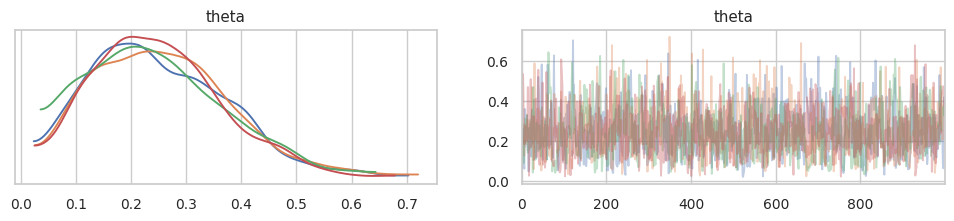

In [13]:
az.plot_trace(idata, compact=False, combined=False)
plt.show()